# Universal Differential Equation for a 2D PDE heat equation

In [1]:
using Pkg; Pkg.activate("../../."); Pkg.instantiate()
using Plots; gr()
using Statistics
using LinearAlgebra
using Zygote
using PaddedViews
using Flux
using Flux: @epochs
using Tullio

  Activating environment at `~/Desktop/Jordi/Julia/odinn_toy_model/Project.toml`


### Parameter declaration

In [2]:
nx, ny = 100, 100 # Size of the grid
Δx, Δy = 1, 1
Δt = 0.01
t₁ = 1

D₀ = 1
tolnl = 1e-4
itMax = 100
damp = 0.85
dτsc   = 1.0/3.0
ϵ     = 1e-4            # small number
cfl  = max(Δx^2,Δy^2)/4.1

0.24390243902439027

In [3]:
function loss(T, θ, p)
    
    uD = θ[1]
    
    T = heatflow(T, uD, p)

    l_H = sqrt(Flux.Losses.mse(T, T₁; agg=mean))

    return l_H
end

loss (generic function with 1 method)

In [4]:
function heatflow(T, D::Real, p, tol=Inf)
   
    Δx, Δy, Δt, t₁ = p
    
    total_iter = 0
    t = 0
    
    while t < t₁
        
        iter = 1
        err = 2 * tolnl
        Hold = copy(T)
        dTdt = zeros(nx, ny)
        err = Inf 
        
        while iter < itMax+1 && tol <= err
            
            Err = copy(T)
                    
            F, dτ = Heat(T, D, p)
            
            @tullio ResT[i,j] := -(T[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)] 
            
            dTdt_ = copy(dTdt)
            @tullio dTdt[i,j] := dTdt_[i,j]*damp + ResT[i,j]
            
            T_ = copy(T)
            #@tullio T[i,j] := max(0.0, T_[i,j] + dTdt[i,j]*dτ[pad(i-1,1,1),pad(j-1,1,1)]) 
            @tullio T[i,j] := max(0.0, T_[i,j] + dτ * dTdt[i,j])
            
            Zygote.ignore() do
                Err .= Err .- T
                err = maximum(Err)
            end 
            
            iter += 1
            total_iter += 1
            
        end
        
        t += Δt
        
    end
    
    return T
    
end

heatflow (generic function with 2 methods)

In [5]:
function Heat(T, D, p)
   
    Δx, Δy, Δt, t₁ = p
    
    #dTdx = diff(S, dims=1) / Δx
    #dTdy = diff(S, dims=2) / Δy

    dTdx_edges = diff(T[:,2:end - 1], dims=1) / Δx
    dTdy_edges = diff(T[2:end - 1,:], dims=2) / Δy
    
    Fx = -D * dTdx_edges
    Fy = -D * dTdy_edges    
    F = .-(diff(Fx, dims=1) / Δx .+ diff(Fy, dims=2) / Δy) 

    dτ = dτsc * min( 10.0 , 1.0/(1.0/Δt + 1.0/(cfl/(ϵ + D))))
    
    return F, dτ
 
end

Heat (generic function with 1 method)

## Generate reference dataset

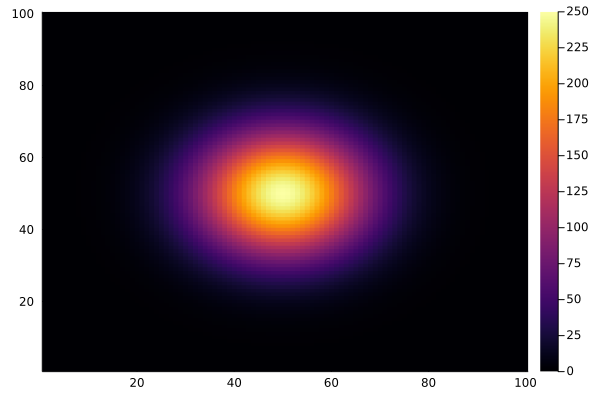

In [6]:
p = (Δx, Δy, Δt, t₁)

T₀ = [ 250 * exp( - ( (i - nx/2)^2 + (j - ny/2)^2 ) / 300 ) for i in 1:nx, j in 1:ny ]

T₁ = copy(T₀)
T₁ = heatflow(T₁, D₀, p, 1e-1)

heatmap(T₀, clim=(0, maximum(T₀)))

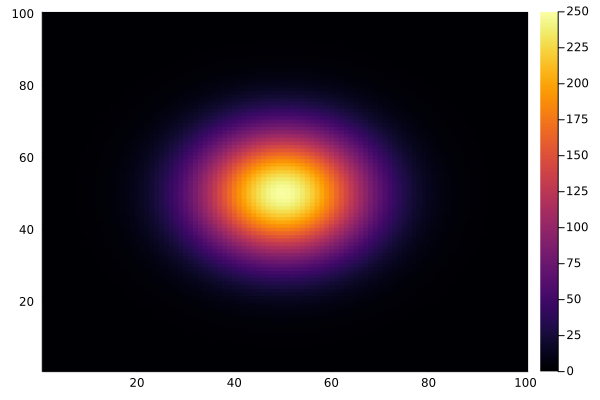

In [7]:
heatmap(T₁, clim=(0, maximum(T₀)))

In [8]:
sqrt( sum((T₁.-T₀).^2) / (nx * ny) )

0.16311579618178718

## Automatic differentiation on the heat equation with respect to D

We perform automatic differentiation on the 2D PDE with respect to the diffusivity (D) in order to optimize it.

In [9]:
T = copy(T₀)

loss_uD, back_uD = Zygote.pullback(D -> loss(T, [D], p), 100)

(2.9749888654073713, Zygote.var"#46#47"{typeof(∂(#20))}(∂(#20)))

We test different D values in order to observe how the loss and the backpropagated gradients change.

In [10]:
#all_D = 10 .^ LinRange(-4, 5, 100)
all_D = LinRange(D₀/2, 2D₀, 100)
all_loss = zeros(0)
all_grad = zeros(0)

for d in all_D
    
    T = T₀
    loss_uD, back_uD = Zygote.pullback(D -> loss(T, D, p), d)
    
    # println(d)
    # println(loss_uD, back_uD(1))
    
    append!(all_loss, loss_uD)
    append!(all_grad, back_uD(1)[1])
end

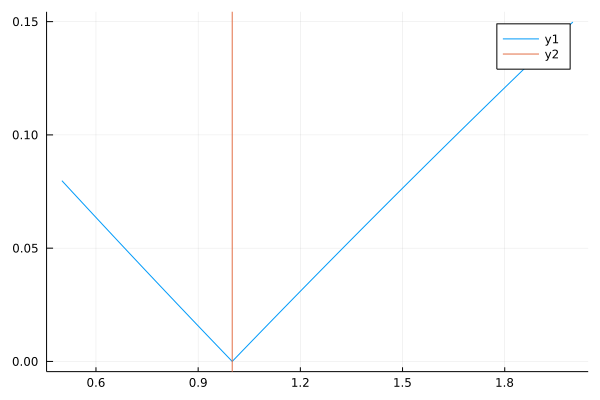

In [11]:
plot(all_D, all_loss)
vline!([D₀])

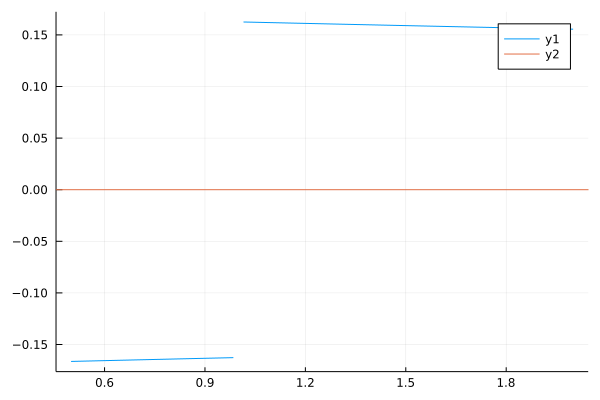

In [12]:
plot(all_D, all_grad)
hline!([0])

## AD with respect to D in order to optimize it

We now use Zygote in order to perform AD on the 2D heat equation and we optimize D using an ADAM gradient descent. 

In [13]:
#Flux.Optimise.update!(opt, x::AbstractMatrix, Δ::AbstractVector) = Flux.Optimise.update!(opt, x, reshape(Δ, size(x)))

In [14]:
function train(loss, p)
    
    θ = [10.]

    opt = ADAM(0.1)
    @epochs 100 hybrid_train!(loss, θ, p, opt)
    
    return θ
    
end

function hybrid_train!(loss, θ, p, opt)
        
    T = T₀
    loss_uD, back_uD = Zygote.pullback(θ -> loss(T, θ, p), θ)
    
    ∇_uD = back_uD(one(loss_uD))[1]
    
    println("Loss: ", loss_uD)
    println("Current parameter: ", θ)
    println("Gradient: ", ∇_uD)
    println("opt: ", opt)
    
    Flux.Optimise.update!(opt, θ, ∇_uD)
    
end

hybrid_train! (generic function with 1 method)

In [15]:
θ₁ = train(loss, p)  #  I STILL GET AN ERROR HERE
D = θ₁[1]

In [16]:
D

LoadError: UndefVarError: D not defined